In [ ]:
# %%capture
# %pip install pytorch-ignite

In [ ]:
# from ignite.engine import Engine, Events
# from ignite.handlers import EarlyStopping
# from ignite.metrics import Loss
# from ignite.contrib.handlers import ProgressBar

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from torch.utils.data import Dataset, random_split
from PIL import Image
from torchvision import transforms

from google.colab import drive
drive.mount('/content/drive')

# make sure you have this Math156 folder or you may have to change this to ur current directory
os.chdir('/content/drive/MyDrive/Colab Notebooks/Math156')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading and preprocessing data

In [ ]:
class PoseDataset(Dataset):
    def __init__(self, annotation_file, root_dir, transform=None):
        self.annotations = []
        with open(annotation_file, 'r') as f:
            for i, line in enumerate(f):
              if i < 3 or i > 10:
                continue

              parts = line.strip().split()
              img_path = parts[0]
              target = list(map(float, parts[1:]))
              self.annotations.append((img_path, torch.tensor(target, dtype=torch.float32)))

        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_rel_path, target = self.annotations[idx]
        img_path = os.path.join(self.root_dir, img_rel_path)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, target

## Channel Attention Module

In [ ]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # [C,1,1]
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_MLP(self.avg_pool(x))
        max_out = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avg_out + max_out) * x

## Spatial Attention Module

In [ ]:
# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size=KERNAL_SIZE
        padding = (kernel_size - 1) // 2

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)         # [B,1,H,W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)         # [B,2,H,W]
        return self.sigmoid(self.conv(x_cat)) * x

## CBAM

In [ ]:
# Combined CBAM
class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

## Convolutional Block / Layer with CBAM

In [ ]:
class BasicBlockWithCBAM(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.cbam = CBAM(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out = self.cbam(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

## PoseRegressor

In [ ]:
class PoseRegressor(nn.Module):
    """ A simple MLP to regress a pose component"""

    def __init__(self, decoder_dim, output_dim, use_prior=False):
        """
        decoder_dim: (int) the input dimension
        output_dim: (int) the outpur dimension
        use_prior: (bool) whether to use prior information
        """
        super().__init__()
        ch = 1024
        self.fc_h = nn.Linear(decoder_dim, ch)
        self.use_prior = use_prior
        if self.use_prior:
            self.fc_h_prior = nn.Linear(decoder_dim * 2, ch)
        self.fc_o = nn.Linear(ch, output_dim)
        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """
        Forward pass
        """
        if self.use_prior:
            x = F.gelu(self.fc_h_prior(x))
        else:
            x = F.gelu(self.fc_h(x))

        return self.fc_o(x)

## ResNet with CBAM

In [ ]:
class ResNetCBAM(nn.Module):
    def __init__(self, block, layers, pos_dim=3, orien_dim=4):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.pos_fc = PoseRegressor(512 * block.expansion, pos_dim)
        self.orien_fc = PoseRegressor(512 * block.expansion, orien_dim)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)  # -> [B, 64, H/4, W/4]
        x = self.layer2(x)  # -> [B, 128, H/8, W/8]
        x = self.layer3(x)  # -> [B, 256, H/16, W/16]
        x = self.layer4(x)  # -> [B, 512, H/32, W/32]

        x = self.avgpool(x)  # -> [B, 512, 1, 1]
        x = torch.flatten(x, 1)

        # → regression output
        position = self.pos_fc(x)
        orientation = self.orien_fc(x)
        output = torch.concat([position, orientation], dim = 1)

        return output

## Train and validation data split

In [ ]:
full_dataset = PoseDataset(annotation_file='KingsCollege/dataset_train.txt', root_dir='KingsCollege')

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

## Train model

In [ ]:
training_loss_tracker = []
validation_loss_tracker = []

KERNAL_SIZE = 7

model = ResNetCBAM(BasicBlockWithCBAM, [2, 2, 2, 2], pos_dim=3, orien_dim=4)  # ResNet18-like
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(100):
    model.train()
    training_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        if epoch % 20 == 0:
            print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        training_loss_tracker.append(loss.item())

        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                validation_loss_tracker.append(loss.item())

        validation_loss /= len(val_loader)

    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.4f}   Validation Loss = {validation_loss:.4f}")

tensor([[ 0.3133, -0.0321,  0.1525,  0.3342, -0.1199, -0.4065,  0.0992],
        [ 0.3458,  0.0517,  0.1030,  0.3466, -0.0750, -0.4476,  0.0571],
        [ 0.3713,  0.0235,  0.1640,  0.2296, -0.0542, -0.4789,  0.0784],
        [ 0.3161,  0.0223,  0.1779,  0.3686, -0.0444, -0.5054, -0.0042],
        [ 0.3528,  0.0533,  0.2114,  0.3954, -0.1032, -0.4623, -0.0452],
        [ 0.3384,  0.0304,  0.2121,  0.3122, -0.1123, -0.4203,  0.0533]],
       device='cuda:0', grad_fn=<CatBackward0>)
Epoch 1: Training Loss = 45.4613   Validation Loss = 41.9343
Epoch 2: Training Loss = 40.9451   Validation Loss = 41.8148
Epoch 3: Training Loss = 37.1143   Validation Loss = 41.5700
Epoch 4: Training Loss = 33.6845   Validation Loss = 41.2197
Epoch 5: Training Loss = 30.5251   Validation Loss = 40.7732
Epoch 6: Training Loss = 27.5635   Validation Loss = 40.2352
Epoch 7: Training Loss = 24.7751   Validation Loss = 39.6098
Epoch 8: Training Loss = 22.1569   Validation Loss = 38.9028
Epoch 9: Training Loss = 

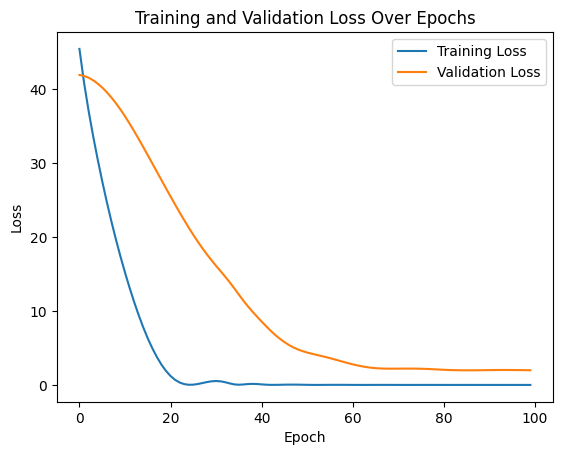

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(training_loss_tracker)), y=training_loss_tracker, label='Training Loss')
sns.lineplot(x=range(len(validation_loss_tracker)), y=validation_loss_tracker, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# # I want to tried the early stopping but it does not stop

# # Model setup
# model = ResNetCBAM(BasicBlockWithCBAM, [2, 2, 2, 2], pos_dim=3, orien_dim=4)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # --- Define training step ---
# def train_step(engine, batch):
#     model.train()
#     imgs, labels = batch
#     imgs, labels = imgs.to(device), labels.to(device)
#     optimizer.zero_grad()
#     outputs = model(imgs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     # Return outputs and labels for the Loss metric
#     return outputs, labels

# # --- Define evaluation step ---
# def eval_step(engine, batch):
#     model.eval()
#     with torch.no_grad():
#         imgs, labels = batch
#         imgs, labels = imgs.to(device), labels.to(device)
#         outputs = model(imgs)
#         return outputs, labels

# # Create trainer and evaluator
# trainer = Engine(train_step)
# evaluator = Engine(eval_step)

# # Attach metrics
# # The Loss metric for the trainer will now receive outputs and labels
# Loss(criterion).attach(trainer, "train_loss")
# Loss(criterion).attach(evaluator, "val_loss")

# # Early stopping
# def score_function(engine):
#     return -engine.state.metrics["val_loss"]  # Lower loss = higher score

# early_stopping = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# evaluator.add_event_handler(Events.COMPLETED, early_stopping)

# # Progress bar
# ProgressBar().attach(trainer)

# # Logging both training and validation loss
# @trainer.on(Events.EPOCH_COMPLETED)
# def log_results(engine):
#     train_loss = engine.state.metrics["train_loss"]
#     evaluator.run(val_loader)
#     val_loss = evaluator.state.metrics["val_loss"]
#     print(f"Epoch {engine.state.epoch} - Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

# # Start training
# trainer.run(train_loader, max_epochs=100)

## Test model

In [ ]:
test_dataset = PoseDataset(annotation_file='KingsCollege/dataset_test.txt', root_dir='KingsCollege')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
total_mse = 0.0
for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
          outputs = model(imgs)
        mse = mean_squared_error(outputs.cpu().numpy(), labels.cpu().numpy())
        total_mse += mse

print(f"Total Mean Square Error:{total_mse}")

Total Mean Square Error:25.144695281982422
